In [1]:
from LogisticRegression import *
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# Data location

In [2]:
data_path = "data/clean_data.csv"
save_directory = "current_accuracies/logistic_regression/logistic_regression_weights"
accuracies_file_path = "current_accuracies/logistic_regression/LogisticRegression_accuracies.pkl"

if not os.path.isdir(save_directory):
    os.mkdir(save_directory)

# Load data

In [3]:
df = pd.read_csv(data_path)

In [4]:
df.shape

(11627, 39)

In [5]:
df.columns

Index(['RANDID', 'SEX', 'TOTCHOL', 'AGE', 'SYSBP', 'DIABP', 'CURSMOKE',
       'CIGPDAY', 'BMI', 'DIABETES', 'BPMEDS', 'HEARTRTE', 'GLUCOSE', 'educ',
       'PREVCHD', 'PREVAP', 'PREVMI', 'PREVSTRK', 'PREVHYP', 'TIME', 'PERIOD',
       'HDLC', 'LDLC', 'DEATH', 'ANGINA', 'HOSPMI', 'MI_FCHD', 'ANYCHD',
       'STROKE', 'CVD', 'HYPERTEN', 'TIMEAP', 'TIMEMI', 'TIMEMIFC', 'TIMECHD',
       'TIMESTRK', 'TIMECVD', 'TIMEDTH', 'TIMEHYP'],
      dtype='object')

In [6]:
df.iloc[:, 1: 23].columns, df.iloc[:, 23: 31].columns

(Index(['SEX', 'TOTCHOL', 'AGE', 'SYSBP', 'DIABP', 'CURSMOKE', 'CIGPDAY', 'BMI',
        'DIABETES', 'BPMEDS', 'HEARTRTE', 'GLUCOSE', 'educ', 'PREVCHD',
        'PREVAP', 'PREVMI', 'PREVSTRK', 'PREVHYP', 'TIME', 'PERIOD', 'HDLC',
        'LDLC'],
       dtype='object'),
 Index(['DEATH', 'ANGINA', 'HOSPMI', 'MI_FCHD', 'ANYCHD', 'STROKE', 'CVD',
        'HYPERTEN'],
       dtype='object'))

In [7]:
print(df.iloc[:, 1: 23].shape[1], df.iloc[:, 23: 31].shape[1])

22 8


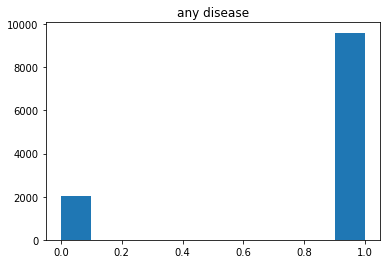

In [8]:
data = np.loadtxt(data_path, delimiter=",", dtype=np.float32, skiprows=1)
amax_label = np.amax(data[:, 23:31], axis=1)
hist,bins = np.histogram(amax_label) 

plt.hist(amax_label, bins = bins) 
plt.title("any disease") 
plt.show()

In [9]:
df

,RANDID,SEX,TOTCHOL,AGE,SYSBP,DIABP,CURSMOKE,CIGPDAY,BMI,DIABETES,...,CVD,HYPERTEN,TIMEAP,TIMEMI,TIMEMIFC,TIMECHD,TIMESTRK,TIMECVD,TIMEDTH,TIMEHYP
0,2448.0,1.0,195.0,39.0,106.0,70.0,0.0,0.0,26.970,0.0,...,1.0,0.0,8766.0,6438.0,6438.0,6438.0,8766.0,6438.0,8766.0,8766.0
1,2448.0,1.0,209.0,52.0,121.0,66.0,0.0,0.0,27.794,0.0,...,1.0,0.0,8766.0,6438.0,6438.0,6438.0,8766.0,6438.0,8766.0,8766.0
2,6238.0,0.0,250.0,46.0,121.0,81.0,0.0,0.0,28.730,0.0,...,0.0,0.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0
3,6238.0,0.0,260.0,52.0,105.0,70.0,0.0,0.0,29.430,0.0,...,0.0,0.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0
4,6238.0,0.0,237.0,58.0,108.0,66.0,0.0,0.0,28.500,0.0,...,0.0,0.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11622,9998212.0,1.0,173.0,46.0,126.0,82.0,0.0,0.0,19.170,0.0,...,0.0,1.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,0.0
11623,9998212.0,1.0,153.0,52.0,143.0,89.0,0.0,0.0,25.740,0.0,...,0.0,1.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,0.0
11624,9999312.0,0.0,196.0,39.0,133.0,86.0,1.0,30.0,20.910,0.0,...,0.0,1.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,4201.0
11625,9999312.0,0.0,240.0,46.0,138.0,79.0,1.0,20.0,26.390,0.0,...,0.0,1.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,4201.0


# Prepare the data

In [10]:
TEST_SPLIT = 0.2
VALIDATION_SPLIT = 0.21
TRAIN_SPLIT = 1 - TEST_SPLIT - VALIDATION_SPLIT

split_proportions = [TRAIN_SPLIT, VALIDATION_SPLIT, TEST_SPLIT]

# Data verification

In [11]:
heart_dataset = HeartDiseaseDataset(data_path, any_disease=False)
train_dataloader_verif, val_dataloader_verif, test_dataloader_verif = create_dataloaders(heart_dataset, batch_size=1, split_proportions=split_proportions)

In [12]:
participant = next(iter(train_dataloader_verif))
print('input ==>\n', participant[0])
print('label ==>\n', participant[1])

input ==>
 tensor([[0.0000, 0.2054, 0.4898, 0.2180, 0.4167, 1.0000, 0.0333, 0.0932, 1.0000,
         0.0000, 0.2623, 0.1913, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.4438, 0.5000, 0.1955, 0.2532]])
label ==>
 tensor([[1., 0.]])


==== Training DEATH ====

Epoch 1 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.2894 - acc: 0.7137 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 888us/step - loss: 0.3429 - acc: 0.7525 - lr: 0.0500
Model saved. Acc updated: -inf -> 0.757
Epoch 2 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.2637 - acc: 0.7378 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 894us/step - loss: 0.0277 - acc: 0.7697 - lr: 0.0500
Model saved. Acc updated: 0.757 -> 0.766
Epoch 3 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.2529 - acc: 0.7610 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 904us/step - loss: 0.0912 - acc: 0.7491 - lr: 0.0500
Epoch 4 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.2485 - acc: 0.7697 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 948us/step - loss: 0.0842 - acc: 0.7884 - lr: 0.05

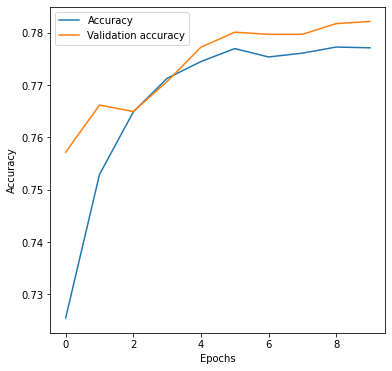




==== Training ANGINA ====

Epoch 1 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.2009 - acc: 0.8542 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 935us/step - loss: 0.0840 - acc: 0.8878 - lr: 0.0500
Model saved. Acc updated: -inf -> 0.890
Epoch 2 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.1665 - acc: 0.8953 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 941us/step - loss: 0.0703 - acc: 0.8979 - lr: 0.0500
Epoch 3 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.1637 - acc: 0.8941 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 929us/step - loss: 0.0386 - acc: 0.8892 - lr: 0.0500
Epoch 4 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.1641 - acc: 0.8908 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 941us/step - loss: 0.0186 - acc: 0.8810 - lr: 0.0500
Epoch 5 / 10
6860/6860 [==========

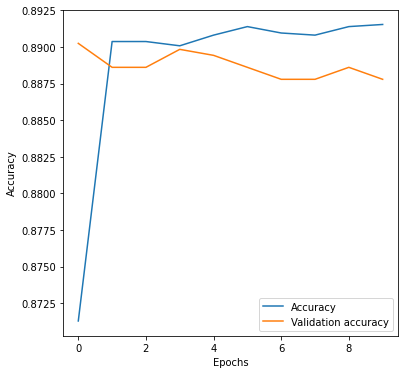




==== Training HOSPMI ====

Epoch 1 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.1625 - acc: 0.8987 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 933us/step - loss: 0.0271 - acc: 0.9020 - lr: 0.0500
Model saved. Acc updated: -inf -> 0.904
Epoch 2 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.1391 - acc: 0.9041 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 931us/step - loss: 0.0179 - acc: 0.9153 - lr: 0.0500
Model saved. Acc updated: 0.904 -> 0.915
Epoch 3 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.1370 - acc: 0.9134 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 942us/step - loss: 1.5888 - acc: 0.9147 - lr: 0.0500
Model saved. Acc updated: 0.915 -> 0.916
Epoch 4 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.1399 - acc: 0.9084 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 934us

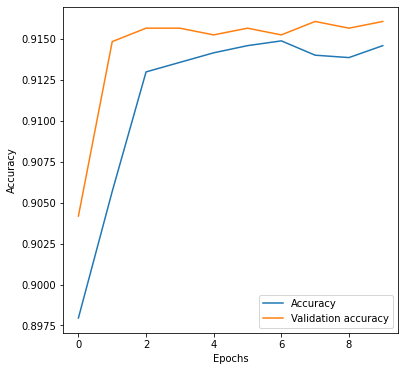




==== Training MI_FCHD ====

Epoch 1 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.2177 - acc: 0.8364 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 930us/step - loss: 0.0338 - acc: 0.8613 - lr: 0.0500
Model saved. Acc updated: -inf -> 0.869
Epoch 2 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.1823 - acc: 0.8656 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 933us/step - loss: 0.1123 - acc: 0.8638 - lr: 0.0500
Epoch 3 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.1764 - acc: 0.8715 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 925us/step - loss: 0.0310 - acc: 0.8689 - lr: 0.05000s -
Model saved. Acc updated: 0.869 -> 0.872
Epoch 4 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.1842 - acc: 0.8584 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 929us/step - loss: 0.1388 - acc: 0.8700 -

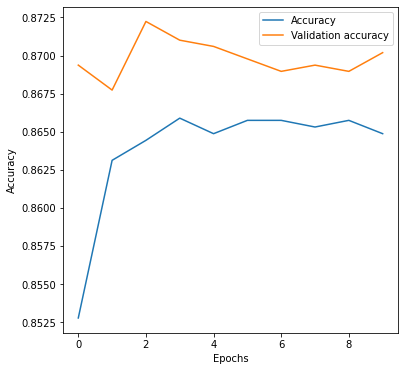




==== Training ANYCHD ====

Epoch 1 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.2654 - acc: 0.7639 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 938us/step - loss: 0.5324 - acc: 0.7846 - lr: 0.0500
Model saved. Acc updated: -inf -> 0.805
Epoch 2 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.2268 - acc: 0.8054 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 925us/step - loss: 0.1047 - acc: 0.7936 - lr: 0.0500
Epoch 3 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.2233 - acc: 0.8060 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 935us/step - loss: 0.0495 - acc: 0.8031 - lr: 0.0500
Epoch 4 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.2240 - acc: 0.8056 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 934us/step - loss: 0.0755 - acc: 0.8092 - lr: 0.0500
Epoch 5 / 10
6860/6860 [==========

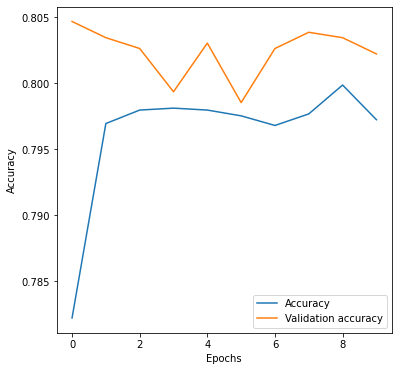




==== Training STROKE ====

Epoch 1 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.1580 - acc: 0.9077 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 922us/step - loss: 0.1170 - acc: 0.9064 - lr: 0.0500
Model saved. Acc updated: -inf -> 0.914
Epoch 2 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.1325 - acc: 0.9110 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 925us/step - loss: 0.3021 - acc: 0.9148 - lr: 0.0500
Model saved. Acc updated: 0.914 -> 0.916
Epoch 3 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.1265 - acc: 0.9154 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 925us/step - loss: 0.0814 - acc: 0.9271 - lr: 0.0500
Model saved. Acc updated: 0.916 -> 0.921
Epoch 4 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.1321 - acc: 0.9098 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 936us

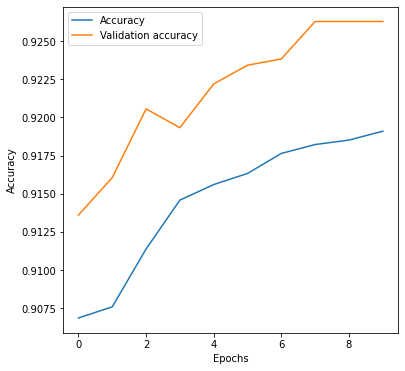




==== Training CVD ====

Epoch 1 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.2685 - acc: 0.7532 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 866us/step - loss: 0.0873 - acc: 0.7822 - lr: 0.0500
Model saved. Acc updated: -inf -> 0.785
Epoch 2 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.2374 - acc: 0.7840 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 873us/step - loss: 0.1394 - acc: 0.7780 - lr: 0.0500
Model saved. Acc updated: 0.785 -> 0.787
Epoch 3 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.2331 - acc: 0.7889 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 870us/step - loss: 0.2866 - acc: 0.7671 - lr: 0.0500
Model saved. Acc updated: 0.787 -> 0.789
Epoch 4 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.2312 - acc: 0.7874 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 872us/st

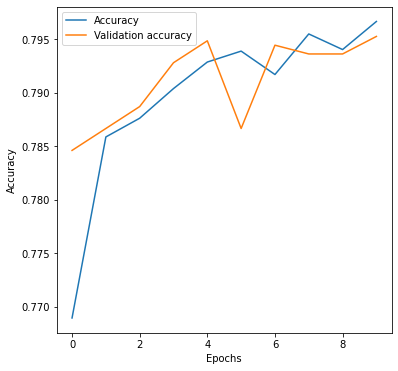




==== Training HYPERTEN ====

Epoch 1 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.2255 - acc: 0.7421 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 865us/step - loss: 0.3348 - acc: 0.7790 - lr: 0.0500
Model saved. Acc updated: -inf -> 0.785
Epoch 2 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.1785 - acc: 0.7913 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 864us/step - loss: 0.2953 - acc: 0.8052 - lr: 0.0500
Model saved. Acc updated: 0.785 -> 0.788
Epoch 3 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.1743 - acc: 0.8051 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 866us/step - loss: 0.0047 - acc: 0.8063 - lr: 0.0500
Model saved. Acc updated: 0.788 -> 0.802
Epoch 4 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.1742 - acc: 0.7966 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 869

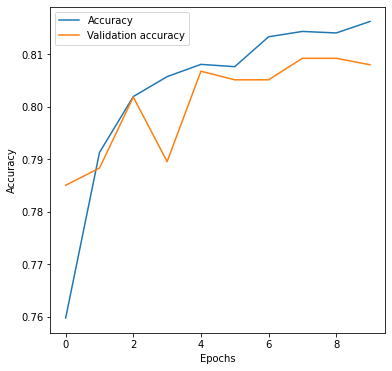

In [13]:
nb_epochs = 10
trainers = train_labels(df.iloc[:, 23: 31].columns, data_path, 
                        df.iloc[:, 23: 31].columns, split_proportions, 
                        save_directory, nb_epochs)

# Test

==== Evaluate DEATH ====

accuracy 78.58064516129032


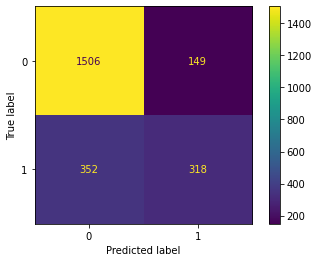

sensitivity : 0.4746268656716418, specificity : 0.9099697885196375, PPV : 0.6809421841541756, NPV : 0.8105489773950484



==== Evaluate ANGINA ====

accuracy 88.08602150537635


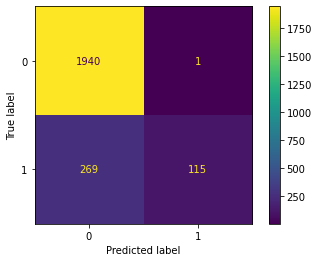

sensitivity : 0.2994791666666667, specificity : 0.9994848016486347, PPV : 0.9913793103448276, NPV : 0.8782254413761883



==== Evaluate HOSPMI ====

accuracy 92.0


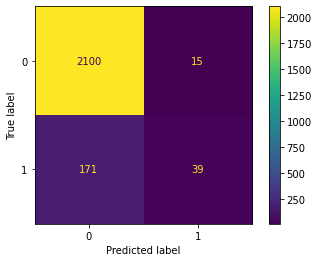

sensitivity : 0.18571428571428572, specificity : 0.9929078014184397, PPV : 0.7222222222222222, NPV : 0.9247027741083224



==== Evaluate MI_FCHD ====

accuracy 88.21505376344086


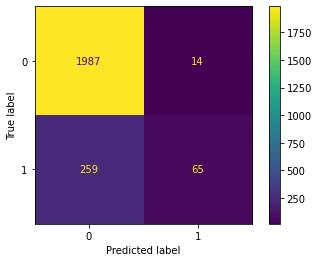

sensitivity : 0.2006172839506173, specificity : 0.9930034982508745, PPV : 0.8227848101265823, NPV : 0.8846838824577026



==== Evaluate ANYCHD ====

accuracy 80.3010752688172


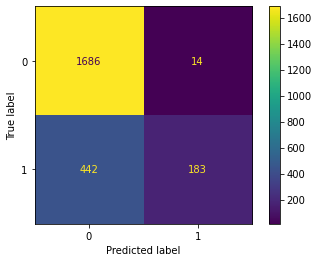

sensitivity : 0.2928, specificity : 0.991764705882353, PPV : 0.9289340101522843, NPV : 0.7922932330827067



==== Evaluate STROKE ====

accuracy 92.04301075268818


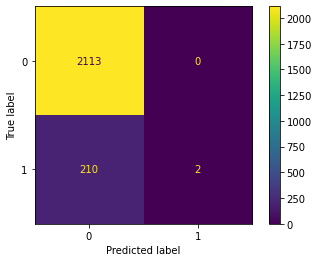

sensitivity : 0.009433962264150943, specificity : 1.0, PPV : 1.0, NPV : 0.9095996556177357



==== Evaluate CVD ====

accuracy 80.64516129032258


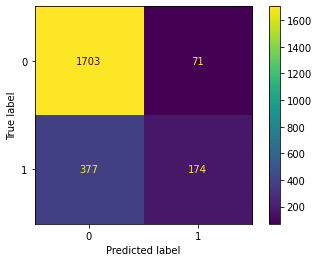

sensitivity : 0.3157894736842105, specificity : 0.9599774520856821, PPV : 0.710204081632653, NPV : 0.81875



==== Evaluate HYPERTEN ====

accuracy 83.13978494623656


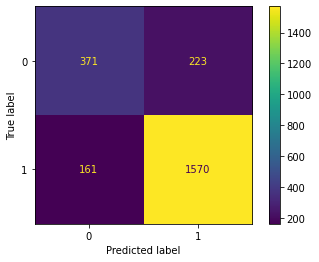

sensitivity : 0.9069901790872328, specificity : 0.6245791245791246, PPV : 0.875627440044618, NPV : 0.6973684210526315





In [14]:
accuracies = prediction_analyse_labels(df.iloc[:, 23: 31].columns, trainers, df.iloc[:, 23: 31].columns, data_path, split_proportions)

In [15]:
save_accuracies_pkl(accuracies_file_path, accuracies)